In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import cv2 as cv
import matplotlib.pyplot as plt
import nibabel as nib

import os

from tensorflow import keras
from keras.layers import (
    Input,
    Conv2D,
    MaxPool2D,
    Conv2DTranspose,
    CenterCrop,
    Concatenate,
)

os.chdir("../../")



In [2]:
DATA_FOLDER = "data/BRATS"


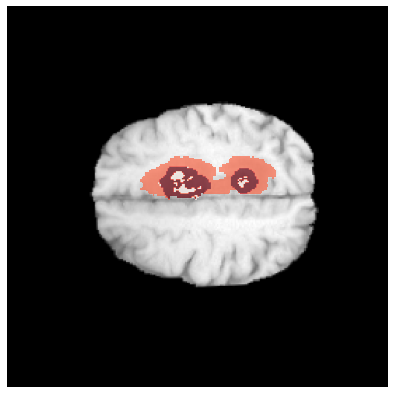

In [13]:
def unify_dimensions_in_classes(segmentation_img: np.array) -> np.array:
    segmentation_img = np.multiply(
        segmentation_img, np.arange(0, segmentation_img.shape[2])
    )
    segmentation_img = np.sum(segmentation_img, axis=2)

    segmentation_norm = (255.0 / segmentation_img.max()) * (
        segmentation_img - segmentation_img.min()
    ).astype(int)

    return segmentation_norm


def plot_image(img_path: str, label_path: str = None):
    img = cv.imread(img_path, cv.IMREAD_GRAYSCALE)

    plt.figure(figsize=(7, 7))
    plt.imshow(img, cmap="gray")

    if label_path:
        label = np.load(label_path)
        label = unify_dimensions_in_classes(label)
        label_masked = np.ma.masked_where(label == 0, label)
        plt.imshow(label_masked, cmap="Reds", alpha=0.7)

    plt.axis("off")
    plt.show()


image = "2_110"
plot_image(f"{DATA_FOLDER}/originals/{image}.png", f"{DATA_FOLDER}/labels/{image}.npy")


In [ ]:
def create_standard_unet(n_classes: int = 2):
    # ======================== CONTRACTING PATH ==========================

    inputs = Input(shape=(512, 512, 1)) 

    conv_1_1 = Conv2D(64, 3, padding='same', activation="relu")(inputs)  
    conv_1_2 = Conv2D(64, 3, padding='same', activation="relu")(conv_1_1)  

    pool_1 = MaxPool2D((2, 2), strides=2)(conv_1_2) 

    conv_2_1 = Conv2D(128, 3, padding='same', activation="relu")(pool_1)  
    conv_2_2 = Conv2D(128, 3, padding='same', activation="relu")(conv_2_1)

    pool_2 = MaxPool2D((2, 2), strides=2)(conv_2_2)  

    conv_3_1 = Conv2D(256, 3, padding='same', activation="relu")(pool_2) 
    conv_3_2 = Conv2D(256, 3, padding='same', activation="relu")(conv_3_1) 

    pool_3 = MaxPool2D((2, 2), strides=2)(conv_3_2)

    conv_4_1 = Conv2D(512, 3, padding='same', activation="relu")(pool_3)
    conv_4_2 = Conv2D(512, 3, padding='same', activation="relu")(conv_4_1)

    pool_4 = MaxPool2D((2, 2), strides=2)(conv_4_2) 

    conv_5_1 = Conv2D(1024, 3, padding='same', activation="relu")(pool_4)
    conv_5_2 = Conv2D(1024, 3, padding='same', activation="relu")(conv_5_1)

    # ======================== EXPANDING PATH ============================

    up_1 = Conv2DTranspose(512, 2, strides=2, padding="same")(conv_5_2) 
    conv_4_2_crop = CenterCrop(up_1.shape[1], up_1.shape[2])(conv_4_2)

    concat_1 = Concatenate()([up_1, conv_4_2_crop]) 
    conv_6_1 = Conv2D(512, 3, padding='same', activation="relu")(concat_1)
    conv_6_2 = Conv2D(512, 3, padding='same', activation="relu")(conv_6_1)

    up_2 = Conv2DTranspose(256, 2, strides=2, padding="same")(conv_6_2) 
    conv_3_2_crop = CenterCrop(up_2.shape[1], up_2.shape[2])(conv_3_2)  

    concat_2 = Concatenate()([up_2, conv_3_2_crop]) 
    conv_7_1 = Conv2D(256, 3, padding='same', activation="relu")(concat_2)
    conv_7_2 = Conv2D(256, 3, padding='same', activation="relu")(conv_7_1) 

    up_3 = Conv2DTranspose(128, 2, strides=2, padding="same")(conv_7_2)
    conv_2_2_crop = CenterCrop(up_3.shape[1], up_3.shape[2])(conv_2_2) 

    concat_3 = Concatenate()([up_3, conv_2_2_crop]) 
    conv_8_1 = Conv2D(128, 3, padding='same', activation="relu")(concat_3)
    conv_8_2 = Conv2D(128, 3, padding='same', activation="relu")(conv_8_1) 

    up_4 = Conv2DTranspose(64, 2, strides=2, padding="same")(conv_8_2) 
    conv_1_2_crop = CenterCrop(up_4.shape[1], up_4.shape[2])(conv_1_2)

    concat_4 = Concatenate()([up_4, conv_1_2_crop]) 
    conv_9_1 = Conv2D(64, 3, padding='same', activation="relu")(concat_4)
    conv_9_2 = Conv2D(64, 3, padding='same', activation="relu")(conv_9_1) 
    conv_9_3 = Conv2D(n_classes, 1, padding='same', activation="softmax")(conv_9_2)

    unet = tf.keras.Model(inputs, conv_9_3)
    return unet


In [ ]:
unet = create_standard_unet(n_classes=5)

unet.summary(line_length=130)
